### Dataset Preparation

First, we will download the dataset from Kaggle using `kagglehub` library.

It will give us the file path to the downloaded folder.

In [ ]:
import os

# dataset loading / metrics
import wandb
import kagglehub
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import PIL.Image as Image

# dataset preparation
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
kagglehub.login()
wandb.login()

In [ ]:
base_path = kagglehub.competition_download(handle='histopathologic-cancer-detection')

print(f'Dataset downloaded to:')
print(base_path)

### Dataset Exploration

We will inspect the downloaded dataset, the files it contains, the format & the content of the files.

In [26]:
print(os.listdir(base_path), "\n")
print(os.listdir(f"{base_path}/train")[:3])
print(os.listdir(f"{base_path}/test")[:3])

['train_labels.csv', 'test', 'sample_submission.csv', 'train'] 

['e56b94476cde09b316084ebf6f03402b76ae3137.tif', 'ba555478a2e3c44172ca3aee1bb50e949f4ffcf1.tif', 'add4d89e28f0beadcd270d63491bac6b5d2d5afd.tif']
['d46c83ab8d1be57c5e2de6489e924358da336e34.tif', 'ed314c4a82ae068d4b4a1abb076e5b61ba2cb327.tif', '565c259b98d5632db52a650f05b00b9646f657b4.tif']


### Exploratory Data Analysis (EDA)

We can see that the dataset contains
- train_labels.csv
- train & test folders (with .tif - image files inside)
- sample_submission.csv (this is for kaggle submission)

Let's start by analyzing the `train_labels.csv` which is our main interest.

In [24]:
df_train = pd.read_csv(f"{base_path}/train_labels.csv")
df_sample = pd.read_csv(f"{base_path}/sample_submission.csv")

In [ ]:
df_train.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [9]:
df_sample.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [11]:
df_train['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [12]:
# check for duplicates
df_train[df_train.duplicated(keep=False)]

Empty DataFrame
Columns: [id, label]
Index: []

#### Observation

We can see that the dataset is fairly large and it will be good enough to train for our use case.

*No duplicates are found.*

### Feature Class balance

We have a total of 220K labels.

1. **malignant** - 89K cases
2. **non-malignant** - 130K cases

This is balance while the dataset favors non-malignant cases.

Next we will inspect the images itself to see how they look like.

#### Malignant Images

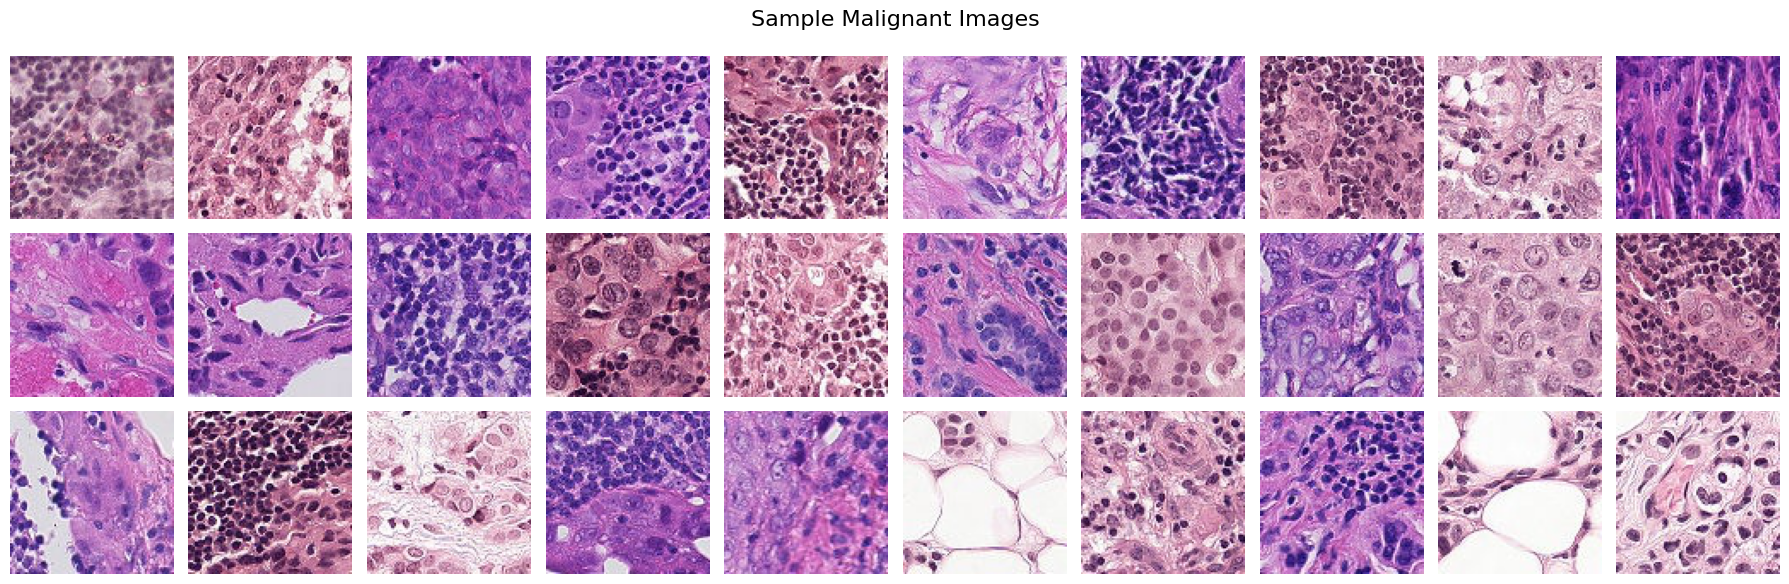

In [13]:
malignant = df_train[df_train['label'] == 1].sample(n=30, random_state=42)['id'].values

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))
axes = axes.flatten()


for index, image_id in enumerate(malignant):
    file_path = f"{base_path}/train/{image_id}.tif"

    img = Image.open(file_path)
    axes[index].imshow(img)
    axes[index].axis('off')

fig.suptitle("Sample Malignant Images", fontsize=16)
plt.tight_layout()
plt.show()

#### Non Malignant / Normal Images

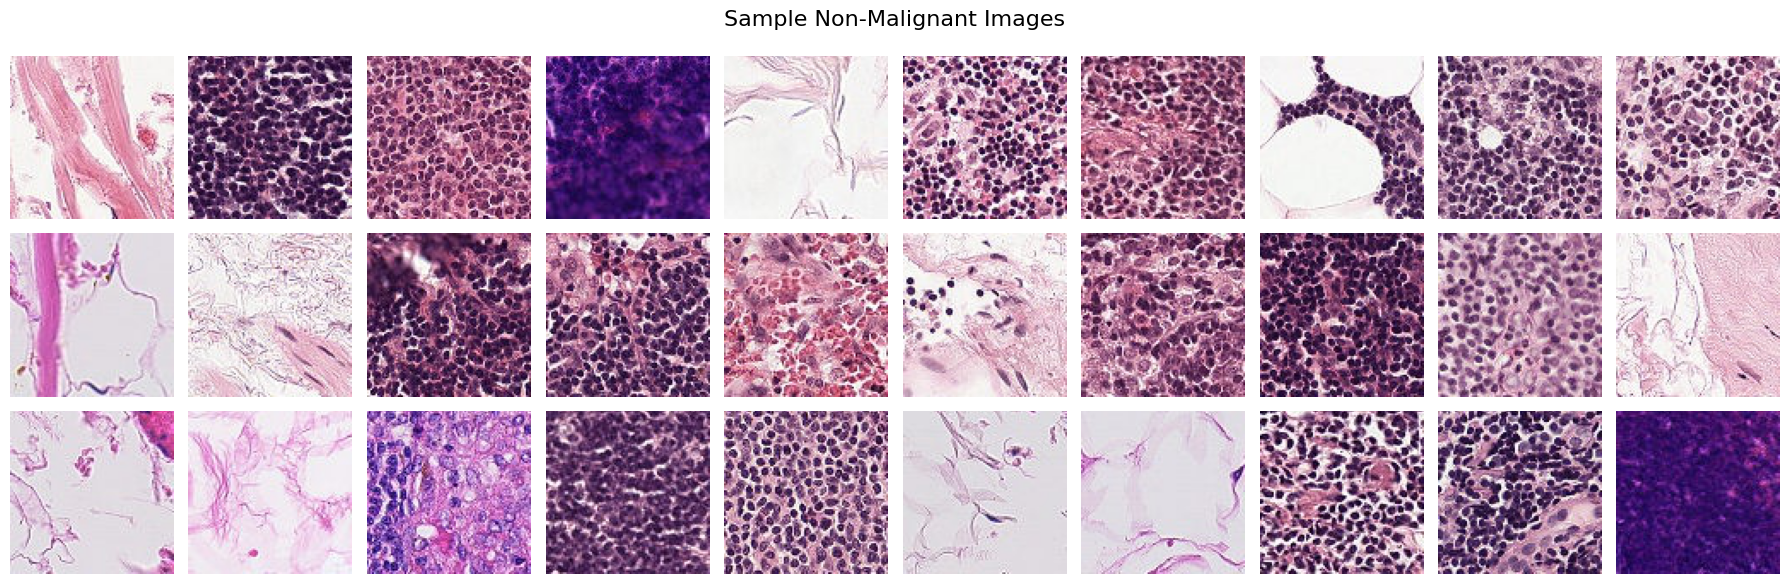

In [14]:
nonmalignant = df_train[df_train['label'] == 0].sample(n=30, random_state=42)['id'].values

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(18, 6))
axes = axes.flatten()


for index, image_id in enumerate(nonmalignant):
    file_path = f"{base_path}/train/{image_id}.tif"

    img = Image.open(file_path)
    axes[index].imshow(img)
    axes[index].axis('off')

fig.suptitle("Sample Non-Malignant Images", fontsize=16)
plt.tight_layout()
plt.show()

### Image Augmentation

Image augmentation will improve model generalization by simulating variations in medical images without altering their labels.

It prevents overfitting by exposing the model to different transformations during training.

The transformations include
- rotation
- horizontal flip
- vertical flip
- resize & cropping

This encourages the model to learn robust, label-invariant features instead of memorizing fixed patterns.

As these are industry best pratices, we won't go into details.

In [15]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),

    # simulates zooming while preserving square aspect ratio
    transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),

    # this helps with over-sharpened images from high-res scans
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),

    transforms.ToTensor(),

    # standard ImageNet mean/std values — these work well with pretrained models
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# minimal transformation for validation dataset
validation_transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

### Dataset Preparation

We will prepare two datasets
1. training
2. validation

and apply the image transformations over each dataset.

In [16]:
class CancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        label = self.dataframe.iloc[idx]['label']

        img_path = os.path.join(self.img_dir, f"{img_id}.tif")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
df_train_split, df_val_split = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['label'],
    random_state=42
)

train_dataset = CancerDataset(df_train_split, img_dir=f"{base_path}/train", transform=train_transforms)
validation_dataset   = CancerDataset(df_val_split, img_dir=f"{base_path}/train", transform=validation_transforms)

### Experiment 1

We will build a pure CNN from scratch using three convolution layers.

1. layer 1 with **32 channels** to extract low-level features (e.g., edges, textures )
2. layer 2 with **64 chennels** to learn more abstract features (e.g., shapes, blobs )
3. layer 3 with **128 channels** to learn high-level overview. (e.g, tumor bountries, structure )

We will apply max pooling at each layer to condense the features.

#### Simple CNN - Model Architecture

In [19]:
import torch.nn as nn

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv_block = nn.Sequential(
        # layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 12 * 12, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 1)
    )

  def forward(self, x):
    x = self.conv_block(x)
    x = self.fc(x)
    return x


#### Training

In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import wandb

num_epochs = 5
batch_size = 64
global_step = 0
log_interval = 10
learning_rate = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
    project="CNN Cancer Detection",
    name="cnn-scratch-baseline-retrain",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": 1e-4,
        "optimizer": "adam",
        "model": "SimpleCNN"
    }
)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for step, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        train_loss += batch_loss * images.size(0)

        global_step += 1
        if step % log_interval == 0:
            wandb.log({"train_loss": batch_loss, "step": global_step})

        progress_bar.set_postfix(loss=f"{batch_loss:.4f}")

    avg_loss = train_loss / len(train_loader.dataset)
    wandb.log({"train_loss": avg_loss, "epoch": epoch+1})

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

#### Validation

In [ ]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(validation_loader, desc="Validating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

auc = roc_auc_score(all_labels, all_probs)
wandb.log({"val_auc": auc})
print(f"Validation AUC: {auc:.4f}")

model_save_path = "simplecnn_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}.")

#### Generate Submission File

In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

test_dir = os.path.join(base_path, 'test')

# define transform for test (same as validation)
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = SimpleCNN()
model.load_state_dict(torch.load("simplecnn_model.pt"))
model.to('cuda')
model.eval()

submission_rows = []

for filename in tqdm(os.listdir(test_dir), desc="Generating Submission"):
    if filename.endswith('.tif'):
        image_path = os.path.join(test_dir, filename)
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to('cuda')

        with torch.no_grad():
            output = model(image)
            prob = torch.sigmoid(output).item()

        submission_rows.append({ "id": filename.split('.')[0], "label": prob })

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("simple-cnn-submission.csv", index=False)

print("submission.csv saved successfully.")

### Experiment 2

We will experiment with `resnet` - residual neural network from Microsoft.

We will build on top of that pre-trained model. It is popular and one of the widely used model due its novel architecture.

**Config**
*   **Model**: Pretrained Resnet 18
*   **Batch Size**: 64
*   **Learning Rate**: 1e-4
*   **Optimizer**: Adam

#### Config & Training

In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torchvision.models as models

batch_size = 64
num_epochs = 5
learning_rate = 1e-4
global_step = 0
log_interval = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = models.resnet18(pretrained=True)

# setting the final layer to output a single value as we want to do binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Combines Sigmoid + Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
    project="CNN Cancer Detection",
    name="resnet18-rerun",
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer": "adam",
        "model": "resnet18"
    }
)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for step, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        train_loss += batch_loss * images.size(0)

        global_step += 1

        if step % log_interval == 0:
            wandb.log({"train_loss": batch_loss, "step": global_step})

        progress_bar.set_postfix(loss=f"{batch_loss:.4f}")

    avg_loss = train_loss / len(train_loader.dataset)
    wandb.log({"train_loss": avg_loss, "epoch": epoch+1})

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


# MODEL VALIDATION

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(validation_loader, desc="Validating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

auc = roc_auc_score(all_labels, all_probs)
wandb.log({"val_auc": auc})
print(f"Validation AUC: {auc:.4f}")

model_save_path = "resnet18.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}.")

#### Generate Submission File

In [ ]:
import os
import torch
import pandas as pd

from PIL import Image
from tqdm import tqdm
from torchvision import transforms, models

test_dir = os.path.join(base_path, 'test')

# test transform - same as validation transform
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)

model.load_state_dict(torch.load("resnet18.pt"))
model.to('cuda')
model.eval()

submission_rows = []

for filename in tqdm(os.listdir(test_dir), desc="Generating ResNet18 Submission"):
    if filename.endswith('.tif'):
        image_path = os.path.join(test_dir, filename)
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to('cuda')

        with torch.no_grad():
            output = model(image)
            prob = torch.sigmoid(output).item()

        submission_rows.append({
            "id": filename.split('.')[0],
            "label": prob
        })

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("resnet18-submission.csv", index=False)

print("resnet18-submission.csv saved successfully.")